# Analyze Interactions

Quick analysis of dynamic interactions and author counts

In [1]:
%matplotlib inline

import os
import re
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split

from collections import Counter
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle
import itertools

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [2]:
data_dir = "/home/levon003/repos/sna-social-support/network_data"
assert os.path.exists(data_dir)

In [37]:
dynamic_auth = pd.read_csv(os.path.join(data_dir, "dynamic_auth.csv"), 
                           header=None, names=['userId', 'authCount', 'firstAuth', 'lastAuth'])
len(dynamic_auth)

566079

In [38]:
author_set = set(dynamic_auth.userId)
len(author_set)

566079

In [5]:
dynamic_ints = pd.read_csv(os.path.join(data_dir, "dynamic_ints.csv"), 
                           header=None, names=['userId', 'intCount', 'firstInt', 'lastInt'])
len(dynamic_ints)

11039858

In [6]:
dynamic_ints.columns

Index(['userId', 'intCount', 'firstInt', 'lastInt'], dtype='object')

In [43]:
interacting_set = set(dynamic_ints.userId)
len(interacting_set)

11039858

In [44]:
# How many users are both authors and interacters?
len(interacting_set & author_set)

228582

In [46]:
# What percent of authors do any kind of interaction?
len(interacting_set & author_set) / len(author_set) * 100

40.37987630701722

In [47]:
# What percent of users that interact with others are visitors?
len(interacting_set - author_set) / len(interacting_set) * 100

97.92948423793132

In [79]:
# What percent of interactions are from visitors?
np.sum(dynamic_ints[dynamic_ints.userId.isin(interacting_set - author_set)].intCount) / np.sum(dynamic_ints.intCount) * 100

91.38856241104295

In [80]:
# What percent of interactions are from authors?
np.sum(dynamic_ints[dynamic_ints.userId.isin(author_set)].intCount) / np.sum(dynamic_ints.intCount) * 100

8.611437588957035

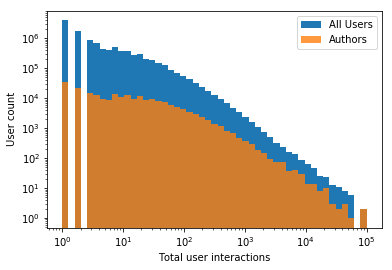

In [41]:
min_ints = 1
max_ints = 100000
n_bins = 50
plt.hist(dynamic_ints.intCount, 
         log=True, bins=np.logspace(np.log10(min_ints),np.log10(max_ints), n_bins),
         label="All Users")
plt.hist(dynamic_ints[dynamic_ints.userId.isin(author_set)].intCount, alpha=0.8,
         log=True, bins=np.logspace(np.log10(min_ints),np.log10(max_ints), n_bins),
         label="Authors")
plt.gca().set_xscale("log")
plt.xlabel("Total user interactions")
plt.ylabel("User count")
plt.legend()
plt.show()

In [15]:
dynamic_ints['int_survival_time'] = dynamic_ints.lastInt - dynamic_ints.firstInt

In [58]:
dynamic_ints['int_survival_time_days'] = dynamic_ints.int_survival_time / 1000 / 60 / 60 / 24

In [81]:
dynamic_auth['auth_survival_time'] = dynamic_auth.lastAuth - dynamic_auth.firstAuth
dynamic_auth['auth_survival_time_days'] = dynamic_auth.auth_survival_time / 1000 / 60 / 60 / 24

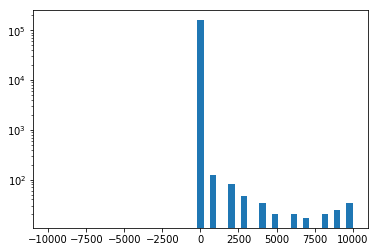

In [104]:
# validating that author survival times are strictly positive
plt.hist(dynamic_auth.auth_survival_time, bins=np.linspace(-10000, 10000), log=True)
plt.show()

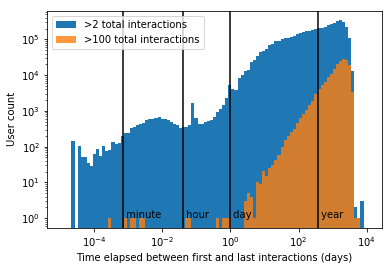

In [76]:
min_ints = 1 / 24 / 60 / 60
max_ints = 1e4
n_bins = 100
plt.hist(dynamic_ints[dynamic_ints.intCount > 2].int_survival_time_days,
         log=True, bins=np.logspace(np.log10(min_ints),np.log10(max_ints), n_bins),
        label=">2 total interactions")
plt.hist(dynamic_ints[dynamic_ints.intCount > 100].int_survival_time_days, alpha=0.8,
         log=True, bins=np.logspace(np.log10(min_ints),np.log10(max_ints), n_bins),
        label=">100 total interactions")
plt.axvline(365, color='black')
plt.text(365, 1, " year")
plt.axvline(1, color='black')
plt.text(1, 1, " day")
plt.axvline(1 / 24, color='black')
plt.text(1 / 24, 1, " hour")
plt.axvline(1 / 24 / 60, color='black')
plt.text(1 / 24 / 60, 1, " minute")
plt.gca().set_xscale("log")
plt.xlabel("Time elapsed between first and last interactions (days)")
plt.ylabel("User count")
plt.legend()
plt.show()

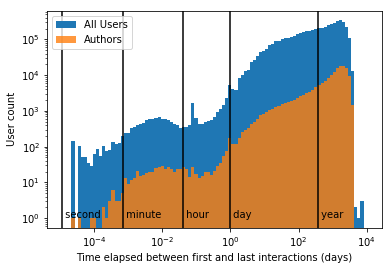

In [75]:
min_ints = 1 / 24 / 60 / 60
max_ints = 1e4
n_bins = 100
plt.hist(dynamic_ints[dynamic_ints.intCount > 2].int_survival_time_days,
         log=True, bins=np.logspace(np.log10(min_ints),np.log10(max_ints), n_bins),
        label="All Users")
plt.hist(dynamic_ints[(dynamic_ints.intCount > 2)&(dynamic_ints.userId.isin(author_set))].int_survival_time_days, alpha=0.8,
         log=True, bins=np.logspace(np.log10(min_ints),np.log10(max_ints), n_bins),
        label="Authors")
plt.axvline(365, color='black')
plt.text(365, 1, " year")
plt.axvline(1, color='black')
plt.text(1, 1, " day")
plt.axvline(1 / 24, color='black')
plt.text(1 / 24, 1, " hour")
plt.axvline(1 / 24 / 60, color='black')
plt.text(1 / 24 / 60, 1, " minute")
plt.axvline(1 / 24 / 60 / 60, color='black')
plt.text(1 / 24 / 60 / 60, 1, " second")
plt.gca().set_xscale("log")
plt.xlabel("Time elapsed between first and last interactions (days)")
plt.ylabel("User count")
plt.legend()
plt.show()

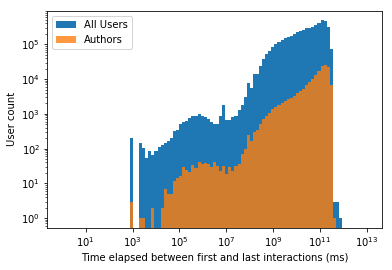

In [63]:
min_ints = 1
max_ints = 1e13
n_bins = 100
plt.hist(dynamic_ints[dynamic_ints.intCount > 2].int_survival_time,
         log=True, bins=np.logspace(np.log10(min_ints),np.log10(max_ints), n_bins),
        label="All Users")
plt.hist(dynamic_ints[(dynamic_ints.intCount > 2)&(dynamic_ints.userId.isin(author_set))].int_survival_time, alpha=0.8,
         log=True, bins=np.logspace(np.log10(min_ints),np.log10(max_ints), n_bins),
        label="Authors")
plt.gca().set_xscale("log")
plt.xlabel("Time elapsed between first and last interactions (ms)")
plt.ylabel("User count")
plt.legend()
plt.show()

In [82]:
merged = pd.merge(dynamic_auth, dynamic_ints, on='userId', how='left', validate='one_to_one')

In [83]:
merged['additional_ints_time_days'] = merged.int_survival_time_days - merged.auth_survival_time_days

In [87]:
np.min(merged.additional_ints_time_days), np.max(merged.additional_ints_time_days)

(-736055.8168402779, 4003.146643518519)

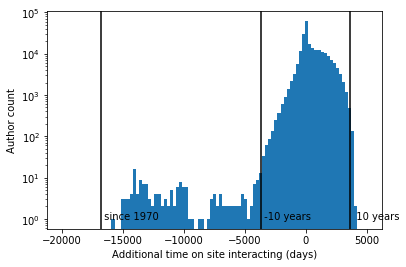

In [103]:
plt.hist(merged.additional_ints_time_days,
         log=True, bins=np.linspace(-20000, 5000, 100))
plt.xlabel("Additional time on site interacting (days)")
plt.ylabel("Author count")
#plt.axvline(365, color='black')
#plt.text(365, 1, " year")
plt.axvline(365 * 10, color='black')
plt.text(365 * 10, 1, "  10 years")
plt.axvline(365 * 10 * -1, color='black')
plt.text(365 * 10 * -1, 1, " -10 years")
plt.axvline(365 * (2016 - 1970) * -1, color='black')
plt.text(365 * (2016 - 1970) * -1, 1, " since 1970")
plt.show()